In [1]:
import  torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from VisionTransformer_model import VIT  # 导入我们之前定义的 VIT B-16 模型
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 绘图显示中文
 
 
# --------------------------------------------- #
#（0）参数设置
# --------------------------------------------- #
batch_size = 16  # 每个step处理16张图片
epochs = 10  # 训练10轮
best_loss = 1.0  # 当验证集损失小于1时才保存权重
 
# 数据集目录位置
filepath = './animals/'
# 预训练权重位置
weightpath = 'jx_vit_base_patch16_224_in21k-e5005f0a.pth'
# 训练时保存权重文件的位置
savepath = './save_weights/'
 
# 获取GPU设备，检测到了就用GPU，检测不到就用CPU
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [2]:
# --------------------------------------------- #
#（1）数据集处理
# --------------------------------------------- #
# 定义预处理方法
data_transform = {
    # 训练集预处理方法
    'train' : transforms.Compose([
        transforms.Resize((224,224)),  # 将原始图片缩放至224*224大小
        transforms.RandomHorizontalFlip(),  # 随机水平翻转
        transforms.ToTensor(),  # numpy类型变tensor，维度调整，数据归一化
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])   # 对图像的三个通道分别做标准化
        ]),
    
    # 验证集预处理方法
    'val' : transforms.Compose([
        transforms.Resize((224,224)),  # 将输入图像缩放至224*224大小
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])
    }
 
 
# 加载数据集
datasets = {
    'train' : datasets.ImageFolder(filepath+'train', transform=data_transform['train']),  # 读取训练集
    'val'   : datasets.ImageFolder(filepath+'val', transform=data_transform['val'])  # 读取验证集
    }
 
 
# 构造数据集
dataloader = {
    'train' : DataLoader(datasets['train'], batch_size=batch_size, shuffle=True),  # 构造训练集
    'val'   : DataLoader(datasets['val'], batch_size=batch_size, shuffle=True)   # 构造验证集
    }
 
 
# --------------------------------------------- #
#（2）查看数据集信息
# --------------------------------------------- #
train_num = len(datasets['train'])  # 查看训练集数量
val_num = len(datasets['val'])  # 查看验证集数量
 
# 查看分类类别及其索引  {0: 'cats', 1: 'dogs', 2: 'panda'}
class_names = dict((v,k) for k,v in datasets['train'].class_to_idx.items())
print(class_names)
 
# 从训练集中取出一个batch，接收图片及其标签
train_imgs, train_labels = next(iter(dataloader['train']))
# 查看图像的标签及其shape  [32, 3, 224, 224]  [32]
print('img:', train_imgs.shape, 'labels:', train_labels.shape)

{0: 'cats', 1: 'dogs', 2: 'panda'}
img: torch.Size([16, 3, 224, 224]) labels: torch.Size([16])


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


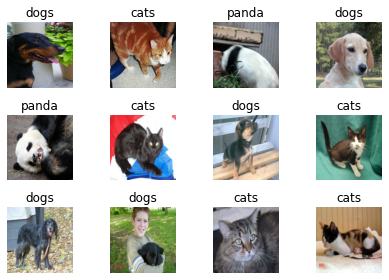

In [3]:
# --------------------------------------------- #
#（3）数据可视化
# --------------------------------------------- #
# 从数据集中取出12张图及其标签
frames = train_imgs[:12]
frames_labels = train_labels[:12]
 
# 将数据类型从tensor变回numpy
frames = frames.numpy()
# 维度调整 [b,c,h,w]==>[b,h,w,c]
frames = np.transpose(frames, [0,2,3,1])
 
# 对图像做反标准化处理
mean = [0.485, 0.456, 0.406]  # 均值
std = [0.229, 0.224, 0.225]   # 标准化
# 图像的每个通道的特征图乘标准化加均值
frames = frames * std + mean
 
# 将像素值限制在0-1之间
frames = np.clip(frames, 0, 1)
 
# 绘制12张图像及其标签
plt.figure()  # 创建画板
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(frames[i])
    plt.axis('off')  # 不显示坐标刻度
    plt.title(class_names[frames_labels[i].item()])  # 显示每张图片的标签
plt.tight_layout()  # 轻量化布局
plt.show()

In [4]:
# --------------------------------------------- #
#（4）模型加载，迁移学习
# --------------------------------------------- #
# 接收VIT模型，三分类
model = VIT(num_classes=3)
 
# 加载预训练权重文件，文件中的分类层神经元个数是1k
pre_weights = torch.load(weightpath, map_location=device)
 
# 删除权重文件中不需要的层，保留除了分类层以外的所有层的权重
del_keys = ['head.weight', 'head.bias']
 
# 删除字典中的对应key
for k in del_keys:
    del pre_weights[k]
 
# 将修改后的权重加载到模型上
# 当strict=True,要求预训练权重层数的键值与新构建的模型中的权重层数名称完全吻合
missing_keys, unexpected_keys = model.load_state_dict(pre_weights, strict=False)
print('miss:', len(missing_keys), 'unexpected:', len(unexpected_keys))
 
# model.parameters() 代表网络的所有参数
for params in model.parameters():
    params.requires_grad = True  # 所有权重参与训练可以更新

miss: 44 unexpected: 54


In [5]:
# --------------------------------------------- #
#（5）网络编译
# --------------------------------------------- #
# 将模型搬运至GPU上
model.to(device)
# 定义交叉熵损失
loss_function = nn.CrossEntropyLoss()
 
# 获取所有需要梯度更新的权重参数
params_optim = []
# 遍历网络的所有权重
for p in model.parameters():
    if p.requires_grad is True:  # 查看权重是否需要更新
        params_optim.append(p)   # 保存所有需要更新的权重
 
print('训练参数：', len(params_optim))
 
# 定义优化器，定义学习率，动量，正则化系数
optimizer = optim.SGD(params_optim, lr=0.001, momentum=0.9, weight_decay=3e-4)
 
 
# --------------------------------------------- #
#（6）训练阶段
# --------------------------------------------- #
for epoch in range(epochs):
    
    print('='*30)  # 显示当前是第几个epoch
 
    # 将模型设置为训练模式
    model.train()
    # 记录一个epoch的训练集总损失
    total_loss = 0.0
 
    # 每个step训练一个batch，每次取出一个数据集及其标签
    for step, (images, labels) in enumerate(dataloader['train']):
        
        # 将数据集搬运到GPU上
        images, labels = images.to(device), labels.to(device)
        # 梯度清零，因为梯度是累加的
        optimizer.zero_grad()
        # 前向传播==>[b,3]
        logits = model(images)  # 得到每张图属于3个类别的分数
        
        #（1）损失计算
        # 计算每个step的预测值和真实值的交叉熵损失
        loss = loss_function(logits, labels)
        # 累加每个step的损失
        total_loss += loss
 
        #（2）反向传播
        # 梯度计算
        loss.backward()
        # 梯度更新
        optimizer.step()
        
        # 每50个epoch打印一次损失值
        if step % 50 == 0:
            print(f'step:{step}, train_loss:{loss}')
 
    # 计算一个epoch的训练集平均损失
    train_loss = total_loss / len(dataloader['train'])
 
# --------------------------------------------- #
#（7）验证训练
# --------------------------------------------- #
    model.eval()  # 切换到验证模式
 
    total_val_loss = 0.0  # 记录一个epoch的验证集总损失
    total_val_correct = 0  # 记录一个epoch中验证集一共预测对了几个
 
    with torch.no_grad():  # 接下来不计算梯度
        # 每个step验证一个batch
        for (images, labels) in dataloader['val']:
 
            # 将数据集搬运到GPU上
            images, labels = images.to(device), labels.to(device)
            # 前向传播[b,c,h,w]==>[b,3]
            logits = model(images)
 
            #（1）计算损失
            # 计算每个batch的预测值和真实值的交叉熵损失
            loss = loss_function(logits, labels)
            # 累加每个batch的损失，得到一个epoch的总损失
            total_val_loss += loss
 
            #（2）计算准确率
            # 找到预测值对应的最大索引，即该图片对应的类别
            pred = logits.argmax(dim=1)  # [b,3]==>[b]
            # 比较预测值和标签值，计算每个batch有多少预测对了
            val_correct = torch.eq(pred, labels).float().sum()
            # 累加每个batch的正确个数，计算整个epoch的正确个数
            total_val_correct += val_correct
        
        # 计算一个epoch的验证集的平均损失和平均准确率
        val_loss = total_val_loss / len(dataloader['val'])
        val_acc = total_val_correct / val_num
 
        # 打印每个epoch的训练集平均损失，验证集平均损失和平均准确率
        print('-'*30)
        print(f'train_loss:{train_loss}, val_loss:{val_loss}, val_acc:{val_acc}')
 
# --------------------------------------------- #
#（8）保存权重
# --------------------------------------------- #
        # 保存最小损失值对应的权重文件
        if val_loss < best_loss:
            # 权重文件名称
            savename = savepath + f'epoch{epoch}_valacc{round(val_acc.item()*100)}%_' + 'VIT.pth'            
            # 保存该轮次的权重
            torch.save(model.state_dict(), savename)
            # 切换最小损失值
            best_loss = val_loss
            # 打印结果
            print(f'weights has been saved, best_loss has changed to {val_loss}')

训练参数： 142
step:0, train_loss:1.1114368438720703
step:50, train_loss:1.0983870029449463
step:100, train_loss:1.0764812231063843
------------------------------
train_loss:1.094860553741455, val_loss:1.0707257986068726, val_acc:0.43199998140335083
step:0, train_loss:1.0828684568405151
step:50, train_loss:1.085648775100708
step:100, train_loss:1.0272400379180908
------------------------------
train_loss:1.0669186115264893, val_loss:1.021673321723938, val_acc:0.46666666865348816
step:0, train_loss:1.0641090869903564
step:50, train_loss:1.0893173217773438
step:100, train_loss:1.0349104404449463
------------------------------
train_loss:1.015662670135498, val_loss:1.0291765928268433, val_acc:0.47066664695739746
step:0, train_loss:1.1037051677703857
step:50, train_loss:1.0373523235321045
step:100, train_loss:0.9503898024559021
------------------------------
train_loss:0.9801107048988342, val_loss:1.0124579668045044, val_acc:0.48133331537246704
step:0, train_loss:0.9715595841407776
step:50, tra

In [13]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
from VisionTransformer_model import VIT
import numpy as np
import matplotlib.pyplot as plt
 
 
# -------------------------------------------------- #
#（0）参数设置
# -------------------------------------------------- #
batch_size = 32  # 每次测试32张图
 
# 测试集文件夹所在位置
file_path = './animals/val'
# 权重参数路径
weights_path = './save_weights/epoch7_valacc52%_VIT.pth'
 
# 获取GPU设备
if torch.cuda.is_available():  # 如果有GPU就用，没有就用CPU
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [14]:
# -------------------------------------------------- #
#（1）构造测试集
# -------------------------------------------------- #
# 定义测试集的数据预处理方法
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),  # 将输入图像的size缩放至224*224
    transforms.ToTensor(),  # numpy边tensor，像素归一化，维度调整
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])  # 对每个通道标准化
    ])
 
# 加载测试集，并预处理
datasets = datasets.ImageFolder(file_path, transform=data_transforms)
 
# 构造测试集
dataloader = DataLoader(datasets, batch_size=batch_size, shuffle=True)
 
# 查看测试集一共有多少张图
test_num = len(datasets)
 
# 获取测试集的分类类别及其索引  {0: 'cats', 1: 'dogs', 2: 'panda'}
class_names = dict((v,k) for k,v in datasets.class_to_idx.items())

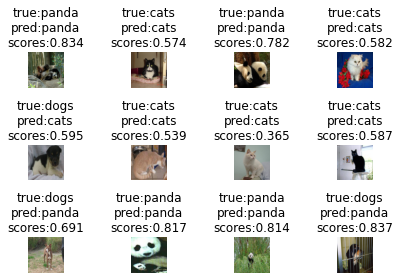

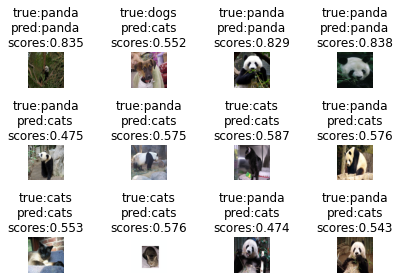

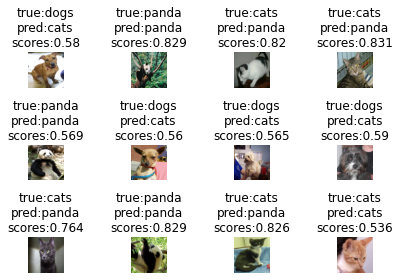

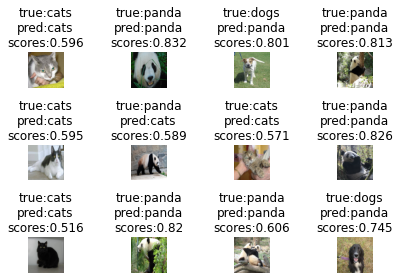

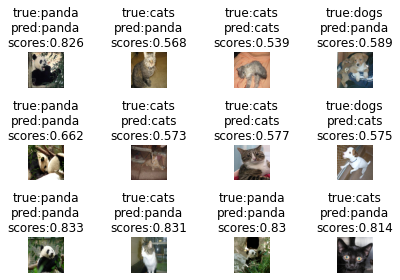

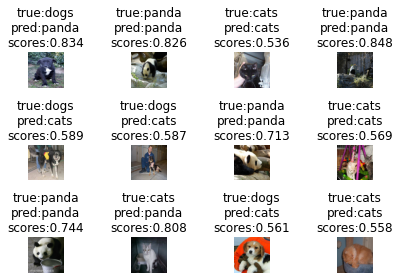

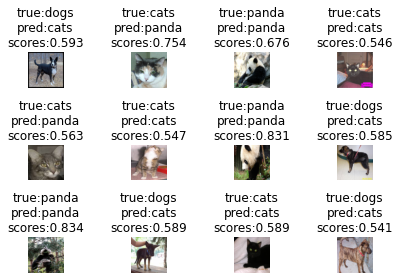

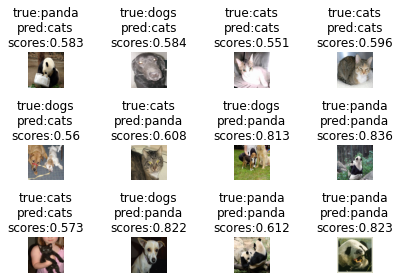

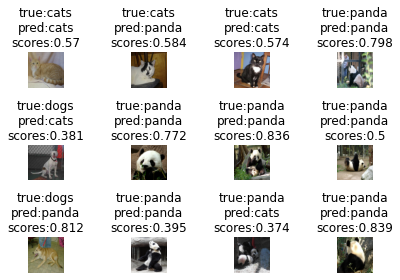

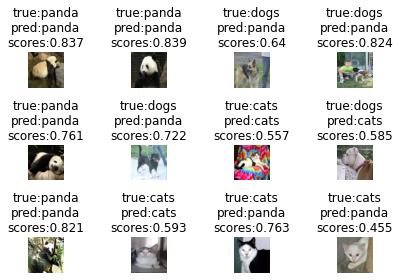

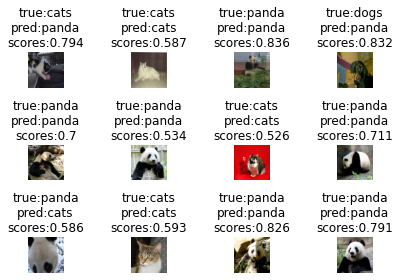

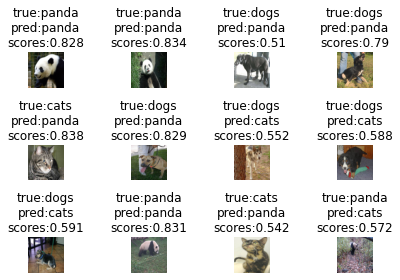

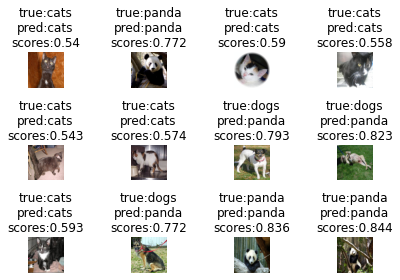

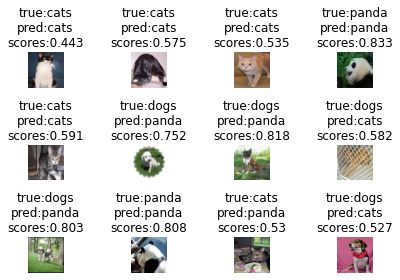

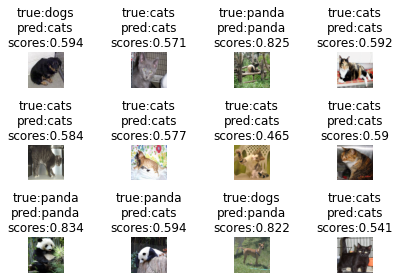

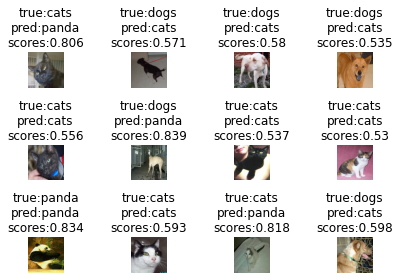

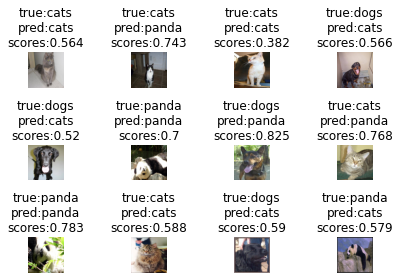

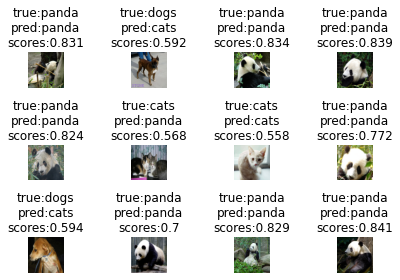

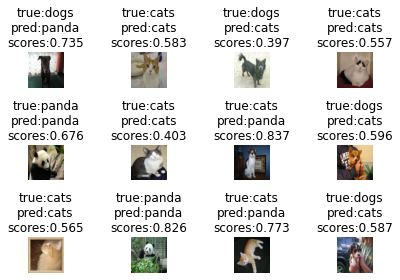

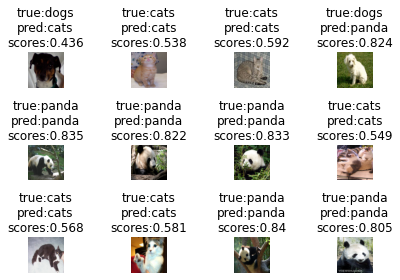

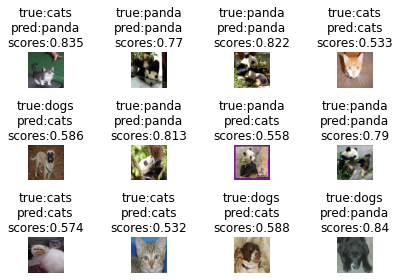

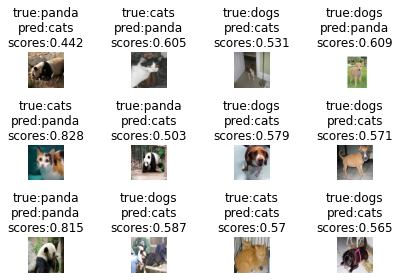

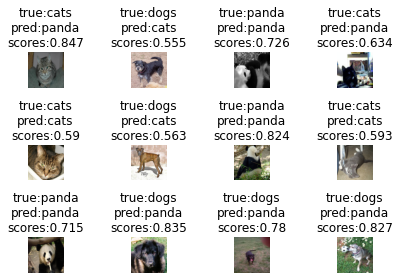

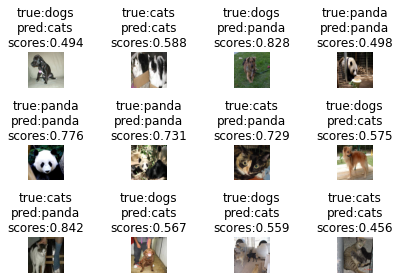

In [15]:
# -------------------------------------------------- #
#（2）绘图展示预测结果
# imgs:代表输入图像[b,c,h,w]，labels代表图像的真实标签[b]
# cls:代表每张图属的类别索引[b]，scores:代表每张图的类别概率[b]
# -------------------------------------------------- #
def im_show(imgs, labels, cls, scores):
    # 从数据集中取出12张图及其标签索引、概率
    frames = imgs[:12]
    true_labels = labels[:12]
    pred_labels = cls[:12]
    pred_scores = scores[:12]
 
    # 将数据类型从tensor变回numpy
    frames = frames.numpy()
    # 维度调整 [b,c,h,w]==>[b,h,w,c]
    frames = np.transpose(frames, [0,2,3,1])
    # 对图像做反标准化处理
    mean = [0.485, 0.456, 0.406]  # 均值
    std = [0.229, 0.224, 0.225]   # 标准化
    # 图像的每个通道的特征图乘标准化加均值
    frames = frames * std + mean
    # 将像素值限制在0-1之间
    frames = np.clip(frames, 0, 1)
 
    # 绘制12张图像及其标签
    plt.figure()  # 创建画板
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(frames[i])
        plt.axis('off')  # 不显示坐标刻度
        # 显示每张图片的真实标签、预测标签、预测概率
        plt.title('true:'+class_names[true_labels[i].item()] + '\n' +
                  'pred:'+class_names[pred_labels[i].item()] + '\n' +
                  'scores:'+str(round(pred_scores[i].item(), 3))
                )  
    
    plt.tight_layout()  # 轻量化布局
    plt.show()
 
 
# -------------------------------------------------- #
#（3）图像预测
# -------------------------------------------------- #
# 模型构建
model = VIT(num_classes=3)
# 加载权重文件
model.load_state_dict(torch.load(weights_path, map_location=device))
# 将模型搬运到GPU上
model.to(device)
# 模型切换成测试模式，切换LN标准化和dropout的工作方式
model.eval()
 
# 测试阶段不计算梯度
with torch.no_grad():
    # 每次测试一个batch
    for step, (imgs, labels) in enumerate(dataloader):
 
        # 将数据集搬运到GPU上
        images, labels = imgs.to(device), labels.to(device)
        # 前向传播==>[b,3]
        logits = model(images)
        # 求出图像属于哪个类别索引[b,3]==>[b]
        pred_cls = logits.argmax(dim=1)
        # 计算图像属于每个类别的概率[b,3]==>[b,3]
        predicts = torch.softmax(logits, dim=1)
        # 获取最大预测类别的概率[b,3]==>[b]
        predicts_score, _ = predicts.max(dim=1)
 
        # 绘制预测结果
        im_show(imgs, labels, pred_cls, predicts_score)